<a href="https://colab.research.google.com/github/safal25/ml_basic_codes/blob/main/YOLOv3_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-01-28 06:21:53--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  4.94MB/s    in 46s     

2021-01-28 06:22:40 (5.15 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
!git clone https://github.com/AlexeyAB/darknet


Cloning into 'darknet'...
remote: Enumerating objects: 14691, done.
remote: Total 14691 (delta 0), reused 0 (delta 0), pack-reused 14691
Receiving objects: 100% (14691/14691), 13.24 MiB | 7.52 MiB/s, done.
Resolving deltas: 100% (9994/9994), done.


In [ ]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [ ]:
from google.colab.patches import cv2_imshow

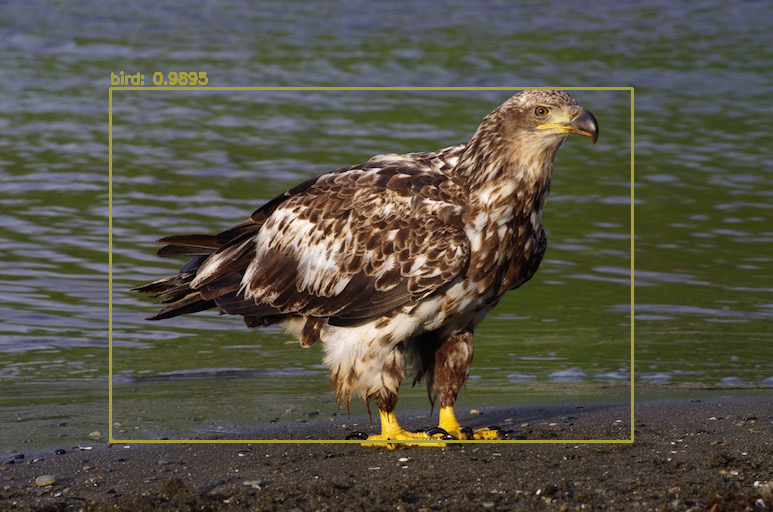

-1

In [ ]:
import numpy as np
import cv2

confidenceThreshold = 0.5
NMSThreshold = 0.3

modelConfiguration = '/content/darknet/cfg/yolov3.cfg'
modelWeights = '/content/yolov3.weights'

labelsPath = '/content/darknet/data/coco.names'
labels = open(labelsPath).read().strip().split('\n')

np.random.seed(10)
COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

image = cv2.imread('/content/darknet/data/eagle.jpg')
(H, W) = image.shape[:2]

#Determine output layer names
layerName = net.getLayerNames()
layerName = [layerName[i[0] - 1] for i in net.getUnconnectedOutLayers()]

blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB = True, crop = False)
net.setInput(blob)
layersOutputs = net.forward(layerName)

boxes = []
confidences = []
classIDs = []

for output in layersOutputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > confidenceThreshold:
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY,  width, height) = box.astype('int')
            x = int(centerX - (width/2))
            y = int(centerY - (height/2))

            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

#Apply Non Maxima Suppression
detectionNMS = cv2.dnn.NMSBoxes(boxes, confidences, confidenceThreshold, NMSThreshold)

if(len(detectionNMS) > 0):
    for i in detectionNMS.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = '{}: {:.4f}'.format(labels[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

cv2_imshow(image)
cv2.waitKey(0)